<a href="https://colab.research.google.com/github/gundaminpde/2022/blob/main/GAN_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 0s 4ms/step
6000 [D loss: 0.547381, acc.: 73.83%] [G loss: 1.974139]
4/4 [==============================] - 0s 3ms/step
7000 [D loss: 0.541565, acc.: 77.73%] [G loss: 1.826735]
4/4 [==============================] - 0s 3ms/step
8000 [D loss: 0.445037, acc.: 80.08%] [G loss: 2.830054]
4/4 [==============================] - 0s 5ms/step
9000 [D loss: 0.308282, acc.: 87.50%] [G loss: 2.678344]
4/4 [==============================] - 0s 4ms/step
10000 [D loss: 0.343178, acc.: 83.59%] [G loss: 2.574097]
1/1 [==============================] - 0s 19ms/step


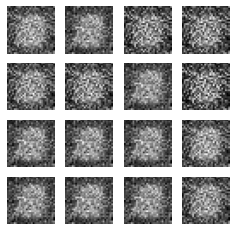

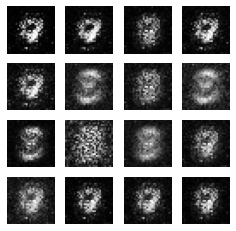

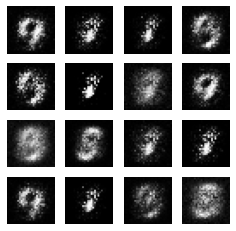

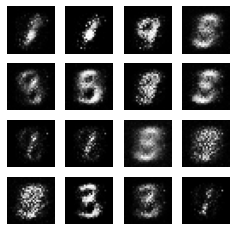

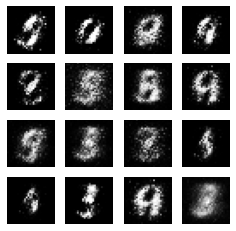

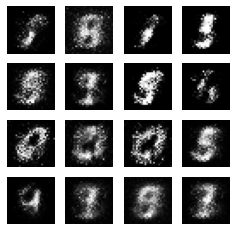

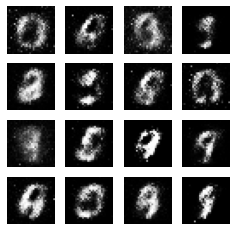

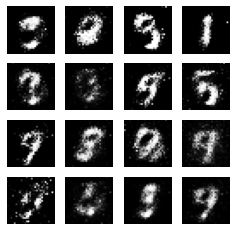

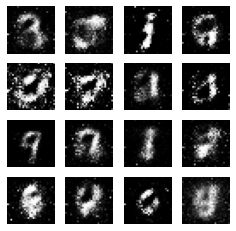

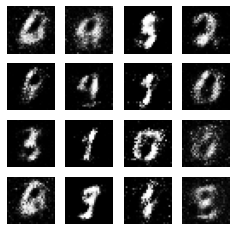

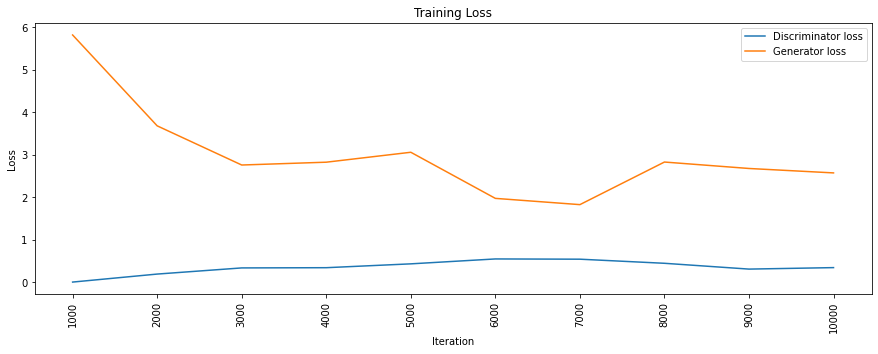

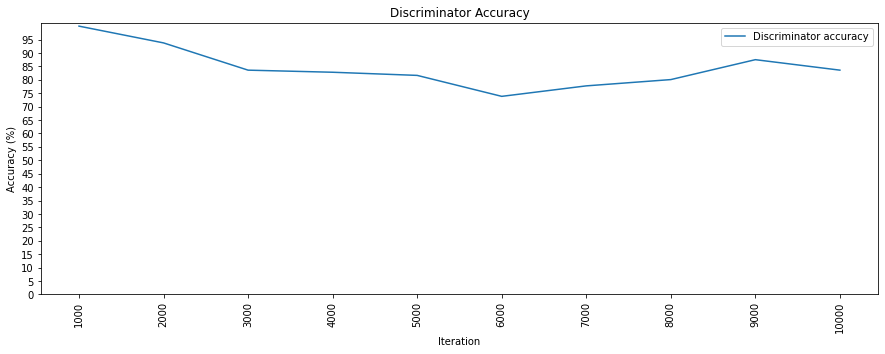

In [1]:
### MNIST dataset으로 부터 손글씨 숫자 만들기 -- 
### https://eochodevlog.tistory.com/97에서 가져온 걸 약간 변형

import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape
from keras.layers import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam


img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)   ### 28x28 크기의 흑백 사진
z_dim = 100


def build_generator(img_shape, z_dim):         ## Generator(위조범)를 위한 신경망 모델
    model = Sequential()
    model.add(Dense(128, input_dim=z_dim))
    model.add(LeakyReLU(alpha=0.01))          ## LeakyReLU를 사용해 보았다.
    model.add(Dense(28 * 28 * 1, activation='tanh'))  ## tanh를 사용해 보았다. -1부터 1까지가 값의 범위
    model.add(Reshape(img_shape))             # 28 * 28 흑백사진. 여기에서 각 픽셀값의 범위는 -1부터 1이다.

    return model


def build_discriminator(img_shape):             ## Discriminator(판별자)를 위한 신경망 모델
    model = Sequential()
    model.add(Flatten(input_shape=img_shape))   # 일단 펴 보았다.
    model.add(Dense(128))                       # 복잡해 봐야 머리만 아프다. 
    model.add(LeakyReLU(alpha=0.01))           
    model.add(Dense(1, activation='sigmoid'))   # 0은 가짜, 1은 진짜로 구분하니 sigmoid를 썼다.

    return model


def build_gan(generator, discriminator):        ## Generator(위조범)을 학습하기 위한 부분이다.
    model = Sequential()                        # 위조범과 판별자를 합체 !!!
    model.add(generator)                       
    discriminator.trainable = False             # 위조범과 판별자를 합체하여 판별자를 속이는 것을 학습한다. 그래서 판별자는 여기에서 학습을 안된다.
    model.add(discriminator) 

    return model

## discriminator, generator, gan이 드디어 등장, 어떻게 compile할지 결정한다.
## img_shape은 28x28의 흑백, z_dim은 위조범에게 줄 latent space의 차원, 100이다.

discriminator = build_discriminator(img_shape)                      
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), 
                      metrics=['accuracy'])


generator = build_generator(img_shape, z_dim)



gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())


losses = []
accuracies = []
iteration_checkpoints = []


def train(iterations, batch_size, sample_interval): ## 가짜 100개 생산 => 가짜128+진짜128개로 판별자 학습 => 가짜 128개로 판별자를 속이도록 위조범 학습

    (X_train, Nah), (Hoon, Arh) = mnist.load_data() ## 우리는 MNIST data 중 X-train만 이용한다. 필요없는 것은 나훈아 씨에게...

    X_train = X_train / 127.5 - 1.0                 ##  data값을 -1과 1사이로 제한하기 위해.... 보통 0과1사이로 1/255로도 많이 한다.
 ###   X_train = np.expand_dims(X_train, axis=3)    ## 저자가 왜 이랬는지 궁금하다.

    real = np.ones((batch_size, 1))                 ## 100개씩 묶어서 학습하려고 한다. 진짜를 위한 정답 [1,1,1,1,...,1] 즉 100개짜리 1
    fake = np.zeros((batch_size, 1))                ## 가짜를 위한 정답 [0,0,0,0,...,1] 즉 100개짜리 0

    for iteration in range(iterations):
        idx = np.random.randint(0, X_train.shape[0], batch_size)   ## 진짜에서 128개의 샘플을 뽑기 위해, 0에서 60000개에서 번호표 100개를 뽑는다.
        imgs = X_train[idx]                         ## 128개의 번호표 해당하는 128개의 진짜 사진을 불러온다.

        z = np.random.normal(0, 1, (batch_size, 100))   ## 위조범이 128개의 가짜를 만들도록 필요한 128개의 random 입력값 z를 만든다. 입력값 z은 100개의 숫자로 이루어진 벡터다.
        gen_imgs = generator.predict(z)              ## 막 만든 입력값을 가지고 128개의 가짜 이미지를 만든다. 

        discriminator.trainable = True ## 새로 추가했음.

        d_loss_real = discriminator.train_on_batch(imgs, real)    ## 적당히 가짜와 진짜를 섞어야 할 것도 같지만, 복잡하므로 먼저 진짜 128개로 판별자 학습
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake) ## 그 다음 가짜 128개로 학습한다. 즉 128개 내리 맞는 것 128개 내리 틀린 것으로 웃기지만 학습했다. 만번이나 학습하는데.... 큰 문제가 없어 보인다.
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)  ## 방금 총 128*2번 학습한 것의 loss값과 정확도를 저장한다.

        z = np.random.normal(0, 1, (batch_size, 100))  ### 이제 위조범을 학습하기 위한 또 128개의 입력값 z를 만든다.

        discriminator.trainable = False ## 새로 추가했음.

        g_loss = gan.train_on_batch(z, real)           ### gan을 불러와서 위조범을 학습는데, gan=위조범+판별자, 그리고 판별자는 학습이 안된다.
                                                       ### 여기서 중요한 것은 "판별자가 가짜를 진짜로 결과가 나오게 하는 것을 목표"로  위조범을 학습하는 것이다.


        if (iteration + 1) % sample_interval == 0:     ### 그래도 가끔은 중간에 보고하고  그림도 보여 주어야 보스가 안심한다. sample_interval을 1000으로 하여 1000번 마다 한번씩 상태를 확인한다.
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            sample_images(generator)                   ### 그림을 그린다.


def sample_images(generator, image_grid_rows=4, image_grid_columns=4):
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    gen_imgs = generator.predict(z)
    gen_imgs = 0.5 * gen_imgs + 0.5              ### 이미지라는 것이 0부터 255까지의 정수거나 0부터 1까지 실수여야 한다. 시작할 때 -1부터 1까지로 변한을 해서 이런 일을 하는 것이다.

    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')  ## cmap='gray'를 써서 흑백이다. 아예없으면 컬러 사진이 나온다. 사실 cmap 옵션이 다양해서 오만가지 방법으로 색을 표현하지만, 고흐같이, 피카소같이는 없다.
            axs[i, j].axis('off')
            cnt += 1


iterations = 10000                ## GAN의 학습을 만번 돌리겠다는 거다.
batch_size = 128                  ## GAN 한번마다 묶음 단위
sample_interval = 1000            ## 보스에게 보고는 1000번에 한번씩

train(iterations, batch_size, sample_interval) ## 학습시작

losses = np.array(losses)

plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

accuracies = np.array(accuracies)

plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()